In [1]:
from yahpo_gym import local_config
import numpy as np
from yahpo_gym import BenchmarkSet
from yahpo_gym import local_config
from yahpo_gym import benchmark_set
import yahpo_gym.benchmarks.rbv2
from ConfigSpace import ConfigurationSpace, Configuration
from smac import Scenario

from smac import HyperparameterOptimizationFacade as HPOFacade
from smac import AlgorithmConfigurationFacade as ACFacade
from smac.initial_design import RandomInitialDesign
from smac.model.random_forest import RandomForest
import matplotlib.pyplot as plt
from smac import constants
from smac.utils.multi_objective import normalize_costs
import pygmo

from smac.acquisition.function.expected_hypervolume import PHVI


[DEBUG][__init__.py:337] matplotlib data path: /home/marco/university/SMAC3-MO/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
[DEBUG][__init__.py:337] CONFIGDIR=/home/marco/.config/matplotlib
[DEBUG][__init__.py:1498] interactive is False
[DEBUG][__init__.py:1499] platform is linux
[DEBUG][__init__.py:337] CACHEDIR=/home/marco/.cache/matplotlib
[DEBUG][font_manager.py:1574] Using fontManager instance from /home/marco/.cache/matplotlib/fontlist-v330.json


In [2]:
# Select a Benchmark
bench = benchmark_set.BenchmarkSet("rbv2_ranger")
# List available instances
print("===bench.instances", len(bench.instances))

Please make sure to also cite:
Binder M., Pfisterer F. & Bischl B. (2020). Collecting Empirical Data About Hyperparameters for Data Driven AutoML. 7th ICML Workshop on Automated Machine Learning.
===bench.instances 119


## Objective function

In [3]:
# OBJECTIVES = 2
OBJECTIVE_NAMES = ["logloss", "timetrain"]

In [4]:
def YAHPO_OBJ(cfg, seed=0):
    """
    Get 2 objectives out of 9.

    output of bench.objective_function(cfg):
       {'acc': 0.9334444,
        'bac': 0.48077813,
        'auc': 0.8760302,
        'brier': 0.04809558,
        'f1': 0.9673253,
        'logloss': 0.17675172,
        'timetrain': 2.7293649,
        'timepredict': 0.22152749,
        'memory': 370.28238}
    """
    assert type(cfg) in [dict, Configuration]
    obj = bench.objective_function(cfg)
    assert len(obj) == 1, "Unhandled situation"
    obj = obj[0]
    obj_filtered = {k: v for k, v in obj.items() if k in OBJECTIVE_NAMES}
    return obj_filtered

sample_cfg = {
    "min.node.size": 97,
    "mtry.power": 0.1708899478404765,
    "num.impute.selected.cpo": "impute.mean",
    "num.trees": 1230,
    "repl": 3,
    "respect.unordered.factors": "ignore",
    "sample.fraction": 0.9036379130493383,
    "splitrule": "extratrees",
    "task_id": "1487",
    "trainsize": 0.9876789129898498,
    "num.random.splits": 33,
}
YAHPO_OBJ(sample_cfg)

{'logloss': 0.17675172, 'timetrain': 2.7293649}

## Scenario

In [5]:
trials = 150

In [6]:
def YAHPO_scenario():
    print("===Warning: using objectives that should raise error")

    # Use the config space from YAHPO Gym
    cs = bench.get_opt_space()

    # Scenario object
    scenario = Scenario(
        configspace=cs,
        deterministic=True,
        objectives=OBJECTIVE_NAMES,
        crash_cost=[0, 0],
        n_trials=trials,
        seed=1,
        n_workers=1,
    )

    # Example call of the function using YAHPO Gym
    config = cs.sample_configuration()
    print(f"YAHPO Gym Evaluation: {YAHPO_OBJ(config)}")

    return scenario, YAHPO_OBJ, OBJECTIVE_NAMES

YAHPO_scenario()

===Warning: using objectives that should raise error
YAHPO Gym Evaluation: {'logloss': 0.5409826, 'timetrain': 4.3971643}


(Scenario(configspace=Configuration space object:
   Hyperparameters:
     min.node.size, Type: UniformInteger, Range: [1, 100], Default: 50
     mtry.power, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.0
     num.impute.selected.cpo, Type: Categorical, Choices: {impute.mean, impute.median, impute.hist}, Default: impute.mean
     num.random.splits, Type: UniformInteger, Range: [1, 100], Default: 1
     num.trees, Type: UniformInteger, Range: [1, 2000], Default: 1000
     repl, Type: UniformInteger, Range: [1, 10], Default: 6
     respect.unordered.factors, Type: Categorical, Choices: {ignore, order, partition}, Default: ignore
     sample.fraction, Type: UniformFloat, Range: [0.1, 1.0], Default: 0.55
     splitrule, Type: Categorical, Choices: {gini, extratrees}, Default: gini
     task_id, Type: Categorical, Choices: {4135, 40981, 4134, 1220, 4154, 4538, 40978, 375, 40496, 40966, 4534, 40900, 40536, 41156, 1590, 1457, 458, 469, 41157, 11, 1461, 1462, 1464, 15, 40975, 41142, 40701

In [7]:
scenario, target_function, _ = YAHPO_scenario()

===Warning: using objectives that should raise error
YAHPO Gym Evaluation: {'logloss': 0.064657636, 'timetrain': 1.1037157}


In [8]:
from smac.callback import Callback
from smac.main.smbo import SMBO
from smac.runhistory import TrialInfo, TrialValue

class CustomCallback(Callback):

    def __init__(self):
        self.trial = 0

    def on_tell_end(self, smbo: SMBO, info: TrialInfo, value: TrialValue) -> bool | None:
        self.trial += 1
        incumbens = smbo.intensifier.incumbents
        smbo.runhistory.incumbents_per_trial[self.trial] = incumbens
        # Continue optimization (return None) or stop if needed (return False)
        return None  # Continue optimization

In [9]:
# ParEGO
smac_pe = ACFacade(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=2),
    model=ACFacade.get_model(scenario),
    callbacks=[CustomCallback()],
)

smac_pe.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:134] Using 2 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:316] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:575] Added config fdaf0a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:622] Config a9ca4d is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:622] Config 37cd4c is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:622] Config 848a20 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:879] Added config 247286 and rejected config 37cd4c as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- min.node.size: 70 -> 49
[INFO][configspace.py:175] --- mtry.power: 0.2804439920644052 -> 0.6940783197565

[Configuration(values={
   'min.node.size': 75,
   'mtry.power': 0.5883371496207906,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 10,
   'num.trees': 430,
   'repl': 9,
   'respect.unordered.factors': 'partition',
   'sample.fraction': 0.7942293980837735,
   'splitrule': 'extratrees',
   'task_id': '4154',
   'trainsize': 0.7047697502167964,
 }),
 Configuration(values={
   'min.node.size': 73,
   'mtry.power': 0.6264961586242938,
   'num.impute.selected.cpo': 'impute.mean',
   'num.random.splits': 10,
   'num.trees': 285,
   'repl': 1,
   'respect.unordered.factors': 'partition',
   'sample.fraction': 0.6259363437908346,
   'splitrule': 'extratrees',
   'task_id': '15',
   'trainsize': 0.6954404572075367,
 }),
 Configuration(values={
   'min.node.size': 19,
   'mtry.power': 0.4628391187082599,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 61,
   'num.trees': 995,
   'repl': 2,
   'respect.unordered.factors': 'order',
   'sample.fractio

In [10]:
from smac.facade.multi_objective_facade import MultiObjectiveFacade as MOFacade

# MO-SMAC
smac_phvi = MOFacade(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=2),
    model=MOFacade.get_model(scenario),
    callbacks=[CustomCallback()],
)

smac_phvi.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:134] Using 2 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:316] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:575] Added config fdaf0a as new incumbent because there are no incumbents yet.


[INFO][abstract_intensifier.py:622] Config a9ca4d is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:622] Config 37cd4c is a new incumbent. Total number of incumbents: 3.
[INFO][abstract_intensifier.py:622] Config 848a20 is a new incumbent. Total number of incumbents: 4.
[INFO][abstract_intensifier.py:622] Config 21acc6 is a new incumbent. Total number of incumbents: 5.
[INFO][abstract_intensifier.py:622] Config b591fd is a new incumbent. Total number of incumbents: 6.
[INFO][abstract_intensifier.py:622] Config faf207 is a new incumbent. Total number of incumbents: 7.
[INFO][abstract_intensifier.py:622] Config d31f43 is a new incumbent. Total number of incumbents: 8.
[INFO][smbo.py:298] Finished 50 trials.
[INFO][abstract_intensifier.py:879] Added config 091af6 and rejected config 37cd4c as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- min.node.size: 70 -> 22
[INFO][configspace.py:175] --- mtry.power

[Configuration(values={
   'min.node.size': 32,
   'mtry.power': 0.6923226156693141,
   'num.impute.selected.cpo': 'impute.hist',
   'num.random.splits': 96,
   'num.trees': 1790,
   'repl': 1,
   'respect.unordered.factors': 'ignore',
   'sample.fraction': 0.25284737760811204,
   'splitrule': 'extratrees',
   'task_id': '40900',
   'trainsize': 0.4384743962549006,
 }),
 Configuration(values={
   'min.node.size': 75,
   'mtry.power': 0.45240482674645155,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 13,
   'num.trees': 957,
   'repl': 5,
   'respect.unordered.factors': 'partition',
   'sample.fraction': 0.4621532678719623,
   'splitrule': 'extratrees',
   'task_id': '4154',
   'trainsize': 0.7806581124388061,
 }),
 Configuration(values={
   'min.node.size': 19,
   'mtry.power': 0.4628391187082599,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 61,
   'num.trees': 995,
   'repl': 2,
   'respect.unordered.factors': 'order',
   'sample.frac

In [11]:
from smac.model.random_forest.random_forest_mo import RandomForestMO
from smac.facade.algorithm_configuration_facade_mo import AlgorithmConfigurationFacadeMO as ACFacadeMO

smac_xgb = ACFacadeMO(
    scenario=scenario,
    target_function=target_function,
    overwrite=True,
    initial_design=RandomInitialDesign(scenario, n_configs=3),
    model=ACFacadeMO.get_model(scenario),
    callbacks=[CustomCallback()],
)

smac_xgb.optimize()

[INFO][abstract_initial_design.py:69] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
===N_TREES 10
[INFO][abstract_initial_design.py:134] Using 3 initial design configurations and 0 additional configurations.
[WARNING][random_forest_mo.py:115] Code below not checked
[INFO][abstract_intensifier.py:316] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:575] Added config d51a67 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:622] Config c2125c is a new incumbent. Total number of incumbents: 2.
===input predict_marginalized (1, 11) [[4.14999983e-01 3.02332573e-01 0.00000000e+00 5.38750000e-01
  2.49999500e-01 2.00000000e+00 1.40386939e-01 1.00000000e+00
  1.04000000e+02 3.90547832e-02 9.49999190e-02]]
==== (1, 11) [[4.14999983e-01 3.02332573e-01 0.00000000e+00 5.38750000e-01
  2.49999500e-01 2.00000000e+00 1.40386939e-01 1.00000000e+00
  1.04000000e+02 3.90547832e-02 9.49999190e-02]]
===input predict_marginal

[Configuration(values={
   'min.node.size': 75,
   'mtry.power': 0.45240482674645155,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 13,
   'num.trees': 957,
   'repl': 5,
   'respect.unordered.factors': 'partition',
   'sample.fraction': 0.4621532678719623,
   'splitrule': 'extratrees',
   'task_id': '4154',
   'trainsize': 0.7806581124388061,
 }),
 Configuration(values={
   'min.node.size': 19,
   'mtry.power': 0.4628391187082599,
   'num.impute.selected.cpo': 'impute.median',
   'num.random.splits': 61,
   'num.trees': 995,
   'repl': 2,
   'respect.unordered.factors': 'order',
   'sample.fraction': 0.3356923636931682,
   'splitrule': 'extratrees',
   'task_id': '1510',
   'trainsize': 0.44383998352009923,
 }),
 Configuration(values={
   'min.node.size': 71,
   'mtry.power': 0.18493502237340165,
   'num.impute.selected.cpo': 'impute.median',
   'num.trees': 1818,
   'repl': 2,
   'respect.unordered.factors': 'partition',
   'sample.fraction': 0.83818221968381

In [12]:
len(bench.instances)

119

In [13]:
from tqdm import tqdm

configurators = {
    "ParEGO": smac_pe,
    "MO-SMAC": smac_phvi,
    "XGB": smac_xgb,
}

color_dict = {
    "ParEGO": "red",
    "MO-SMAC": "blue",
    "XGB": "green",
}

def get_mean_performance(configuration: Configuration, repetitions=10):
    # This was the old way of getting average cost from training
    # return configurator.runhistory.average_cost(configuration, normalize=False)

    scores = []
    for i in bench.instances:
        bench.set_instance(i)
        for s in range(repetitions):
            targets = bench.objective_function(configuration, seed=s)[0]
            scores.append([targets[o] for o in OBJECTIVE_NAMES]) 
    return np.mean(scores, axis=0)


costs_list_all = []
for configname, configurator in configurators.items():
    # Get all configs
    configs = configurator.runhistory.get_configs_per_budget()
    # configs = configs[:10]
    print(f"Computing {len(configs)} configs -> {configname}")
    configurator_costs = [get_mean_performance(c) for c in configs]
    costs_list_all.append((configname, configurator_costs))
    assert len(OBJECTIVE_NAMES) == 2, "This computation is supposed to be for plots, should only be 2 objectives"

costs_list_incumbents = []
for configname, configurator in configurators.items():
    # Get incumbent configs
    configs = configurator.runhistory.incumbents
    # configs = configs[:10]
    print(f"Computing {len(configs)} configs -> {configname}")
    configurator_costs = [get_mean_performance(c) for c in configs]
    costs_list_incumbents.append((configname, configurator_costs))
    assert len(OBJECTIVE_NAMES) == 2, "This computation is supposed to be for plots, should only be 2 objectives"

Computing 150 configs -> ParEGO


KeyboardInterrupt: 

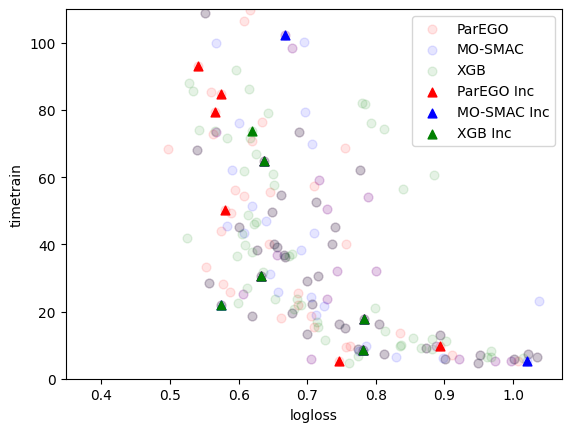

In [ ]:
for configname, configurator_costs in costs_list_all:
    plt.scatter(*list(zip(*configurator_costs)), label=configname, marker="o", alpha=0.1, s=40, color=color_dict[configname])
for configname, configurator_costs in costs_list_incumbents:
    plt.scatter(*list(zip(*configurator_costs)), label=f"{configname} Inc", marker="^", color=color_dict[configname], s = 40)

plt.xlabel(OBJECTIVE_NAMES[0])
plt.ylabel(OBJECTIVE_NAMES[1])
plt.ylim(0, 110)
# plt.xlim(0, 0.5)
plt.legend(loc='upper right')
plt.show()

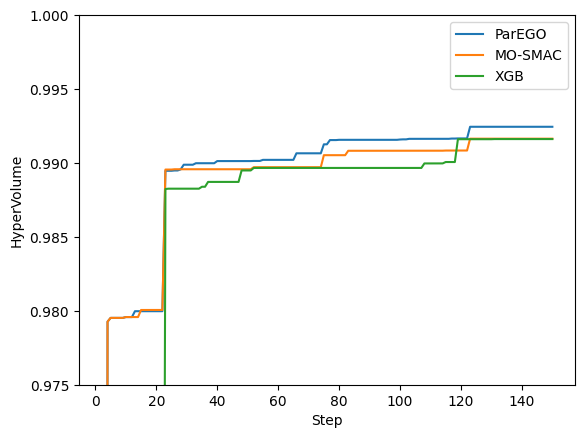

In [ ]:

for configname, configurator in configurators.items():
    hv_list = []
    for step, incumbents in configurator.runhistory.incumbents_per_trial.items():
        # First Step does not have incumbents
        if len(incumbents) == 0:
            continue

        incumbents_cost = np.array([configurator.runhistory.average_cost(i, normalize=False) for i in incumbents])

        """Scale max -> 1
            From:
                [[0.36091729 1.35085459], [0.35206562 1.99654226]]
            To:
                [[0.90229325 0.05873281], [0.88016413 0.08680628]]
        """
        max_x1 = 1.8
        max_x2 = 500.0
        incumbents_cost[:, 0] = incumbents_cost[:, 0] / max_x1
        incumbents_cost[:, 1] = incumbents_cost[:, 1] / max_x2

        hv = pygmo.hypervolume(incumbents_cost)
        hv = hv.compute([1.0, 1.0])
        hv_list.append((step, hv))
    
    hv_list = np.array(hv_list)
    plt.plot(hv_list[:, 0], hv_list[:, 1], label=configname)
    plt.ylim(0.975, 1)
    plt.xlabel("Step")
    plt.ylabel("HyperVolume")
    plt.legend()

## Sample 1000 points

In [ ]:
import numpy as np

# Sample 1000 points from the surrogate model
configs = [bench.config_space.sample_configuration() for _ in range(5)]

configs_arr = np.array([c.get_array() for c in configs])

# Use the BenchmarkSet's objective_function to get the true outputs from the surrogate model
true_outputs = bench.objective_function(configs)


# Convert the list of dictionaries to a numpy array for further processing
# Assuming you want to compare a specific metric, e.g., 'acc'
# true_outputs = np.array([output[OBJECTIVE_NAMES[0]] for output in true_outputs])
# true_outputs = [np.array(list(output.values())) for output in true_outputs_list]


for facade in [smac_pe]: # smac_phvi, smac_xgb
    preds = np.array(facade._model.predict(configs_arr))
    print("preds", preds)
    assert preds.shape[2] == 1
    # Pred: (2, 10, 1) -> (2, 10)
    preds = preds[:, :, 0]

    reals = bench.objective_function(configs)
    reals_ls = []
    for obj_id, obj in enumerate(OBJECTIVE_NAMES):
        reals_ls.append([r[obj] for r in reals])
    reals_ls = np.array(reals_ls)

    distances = np.sqrt((preds - reals_ls)**2)

    """e.g. (to remove once working):
    preds.shape (2, 5) [[0.2859303  0.3176561  0.19147114 0.14932746 0.12483773]
                        [0.03948198 0.03474449 0.01767854 0.01071586 0.00096677]]
    reals_ls.shape (2, 5) [[ 0.8360589   0.16040315  0.49116343  0.64661497  0.5283323 ]
                        [42.34035    22.762796    2.6847465   2.9371884   1.7238945 ]]
    distances (2, 5) [[ 0.55012862  0.15725295  0.29969229  0.4972875   0.40349456]
                        [42.30086913 22.72805191  2.66706796  2.92647253  1.72292771]]
    """

    print("Distances -", facade, "-", OBJECTIVE_NAMES, "=>", distances.sum(axis=1))

preds [[[2.16813549e-01]
  [8.61970319e-02]
  [2.87925740e-01]
  [1.39140812e-01]
  [7.20158625e-02]]

 [[3.85625403e-02]
  [7.24109732e-03]
  [6.24093469e-02]
  [4.03007464e-02]
  [1.23558788e-04]]]
Distances - <smac.facade.algorithm_configuration_facade.AlgorithmConfigurationFacade object at 0x7f425ebdba60> - ['logloss', 'timetrain'] => [  13.04300693 2078.77664042]
